## Capstone project: Prediction

### Overview
### The data

The dataset represents PCB design projects data collected from various places and periods of time. 
The dataset contains 345 entries and 19 features. The dataset is complete with no missing values and has both numerical and categorical data.
The features include physical characteristics of the boards designed, plus a number of descriptive characteristics.


Features description:

Numerical:
* ID - automatically assigned ID number 
* viano - number of vias
* pins - number of pins
* layno - number of layers
* sq - layout area
* dens - layout density
* netno - number of nets
* comp - number of components
* duration - layout design duration
* level - engineer expertise level

Categorical:

* line -  product line (various)
* fit - board utilization (such as daughter board, mlb, etc.)
* viatech - via technology (tht, combinations, etc.)
* dbl - single or double sided
* category - board tech, rigid or flexible
* ver - board version
* complexity - board complexity (low, medium or high)
* scope - scope of the design (new board, minor or major modification)
* type - board family type (such as test, production, etc.)


#### The scope of this capstone project is to find the best regression model to predict the design time (‘duration’) and to determine which features contribute the most to the model.

### Business understanding

Usually the design time is estimated by the engineers or managers who are directly involved in the design, based on objective and subjective factors such as personal experience. A tool which uses only projects' features and eliminates the subjective factors, and which consistently provides good estimations, would considerably improve the resource planning and projects' scheduling. Plus the tool can be used by anybody, such as non-technical teams, project managers, etc. The tool can also learn along and the data can improve as a result of the feature importance results.

### What is the data task here?

1. Can I use the available data to build a design duration prediction tool that can help the management to plan the schedules better?
2. What data can be ignored, or dropped from the analysis?
3. Do I need to clean up the data and how do I prepare the data?
4. What are the top features that influence the duration of a project?
5. Is the model accurate enough? What is missing, how can I improve the data set and the analysis as next steps? 

### Data understanding

Getting familiar with the data and identifying quality issues. 

In [1]:
# Import the necessary libraries from pandas, sklearn, and visualization libraries
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce

from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer
from sklearn.preprocessing import QuantileTransformer, quantile_transform
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, StandardScaler

from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_absolute_error
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, roc_curve
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')
from sklearn import set_config
set_config(display="diagram")

In [2]:
# Import the data
df = pd.read_csv('projects_wrk36636.csv')
df

,ID,line,fit,viatech,viano,pins,layno,sq,dens,dbl,netno,comp,category,ver,complexity,scope,type,duration,level
0,299437,jbr,bb,tht,2,8,2,4.75,8.313,sgl,3,3,FP,M00,Medium,NEW BRD,FF,40,4
1,295634,bis,sns,tht,4,20,2,0.21,0.148,dbl,4,6,RG,R2,Medium,MOD-MINOR,FF,73,5
2,50911,gq,bb,tht,4,26,2,2.04,1.098,sgl,12,2,FP,D0,Low,MOD-MINOR,FF,9,5
3,46382,gq,bb,tht,4,26,2,2.04,1.098,sgl,12,2,FP,E0,Medium,MOD-MINOR,FF,76,5
4,306078,ced,bb,tht,5,20,2,6.30,4.411,sgl,10,2,FP,B0,Low,NEW BRD,FF,43,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,266783,tgr,mlb,astk,97232,5709,12,80.28,0.197,dbl,817,1401,RG,E0,High,MOD-MAJOR,FF,75,5
341,295796,tsk,mlb,astk,102838,9484,12,142.77,0.211,dbl,1346,2173,RG,M0,High,NEW BRD,FF,85,5
342,306338,tgr,mlb,astk,103219,5711,12,80.01,0.196,dbl,812,1402,RG,E2,High,MOD-MINOR,FF,48,5
343,328206,tgr,mlb,astk,103329,5718,12,80.01,0.196,dbl,810,1405,RG,D0,High,MOD-MAJOR,FF,63,5


Note: we can drop the ID column since these are automatically generated numbers

In [3]:
# drop column 'ID'
df = df.drop(columns = ['ID'])

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   line        345 non-null    object 
 1   fit         345 non-null    object 
 2   viatech     345 non-null    object 
 3   viano       345 non-null    int64  
 4   pins        345 non-null    int64  
 5   layno       345 non-null    int64  
 6   sq          345 non-null    float64
 7   dens        345 non-null    float64
 8   dbl         345 non-null    object 
 9   netno       345 non-null    int64  
 10  comp        345 non-null    int64  
 11  category    345 non-null    object 
 12  ver         345 non-null    object 
 13  complexity  345 non-null    object 
 14  scope       345 non-null    object 
 15  type        345 non-null    object 
 16  duration    345 non-null    int64  
 17  level       345 non-null    int64  
dtypes: float64(2), int64(7), object(9)
memory usage: 48.6+ KB


In [5]:
# check for any NaN
df.isnull().sum()

line          0
fit           0
viatech       0
viano         0
pins          0
layno         0
sq            0
dens          0
dbl           0
netno         0
comp          0
category      0
ver           0
complexity    0
scope         0
type          0
duration      0
level         0
dtype: int64

#### Explore the data looking at the correlations and the features. We use the entire dataset and all the features

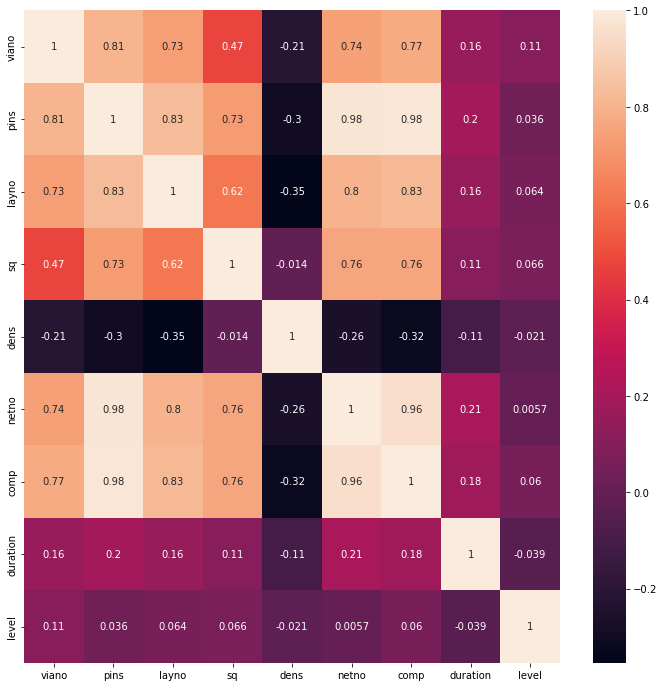

In [6]:
# correlation matrix
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(df.corr(), annot=True);

Notes: there is high correlation, close to 1 between some of the features, we might want to remove some of the features which are correlated. 
There is positive correlation between the duration and the physical features as expected. 

Explore the data

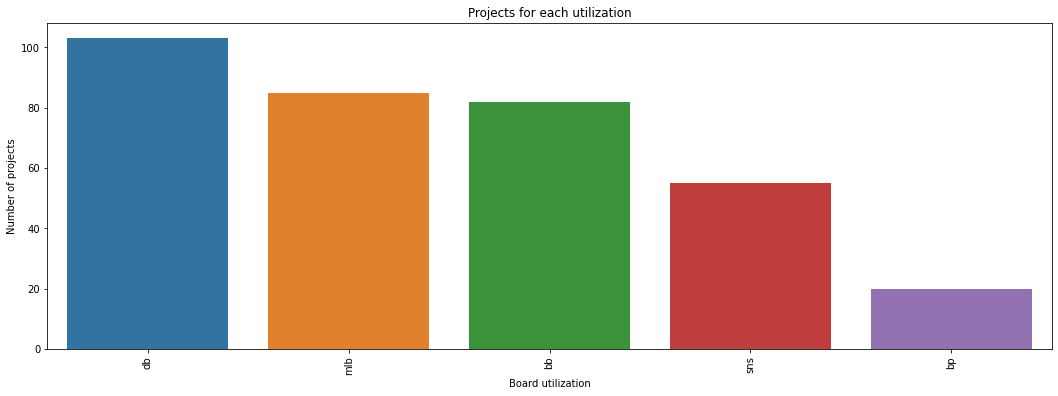

In [7]:
#explore projects of each type
plt.figure(figsize=(18, 6))
sns.countplot(df['fit'],order = df['fit'].value_counts().index)
plt.xticks(rotation = 90);
plt.xlabel('Board utilization')
plt.ylabel('Number of projects')
plt.title('Projects for each utilization');

Note: daughter board and mlb are the highest number, followed by board-to-board

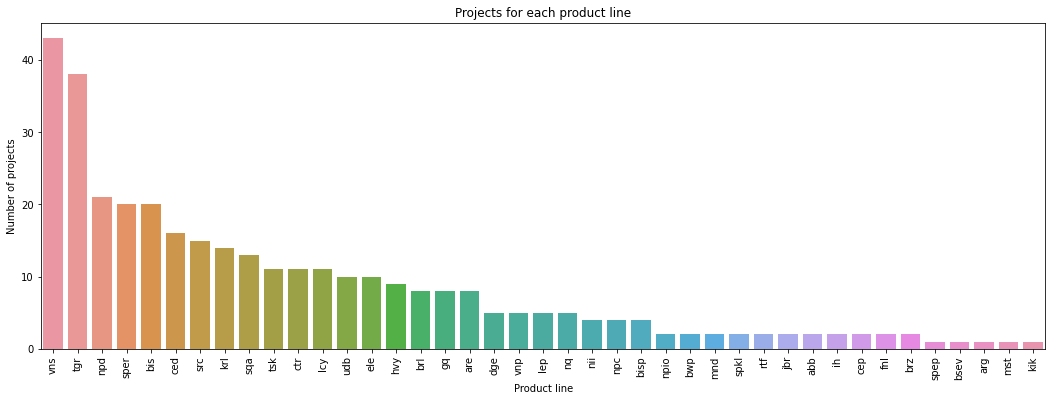

In [8]:
#explore projects of each product line
plt.figure(figsize=(18, 6))
sns.countplot(df['line'],order = df['line'].value_counts().index)
plt.xticks(rotation = 90);
plt.xlabel('Product line')
plt.ylabel('Number of projects')
plt.title('Projects for each product line');

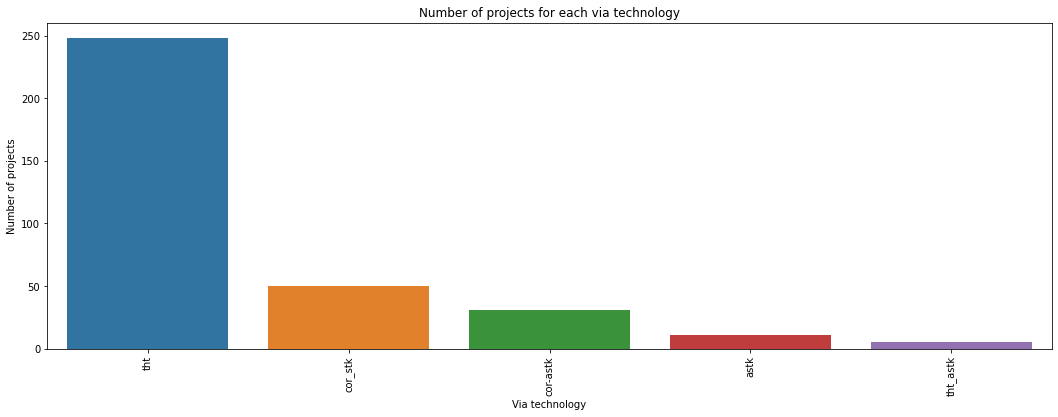

In [9]:
# explore projects by via technology
plt.figure(figsize=(18, 6))
sns.countplot(df['viatech'],order = df['viatech'].value_counts().index)
plt.xticks(rotation = 90);
plt.xlabel('Via technology')
plt.ylabel('Number of projects')
plt.title('Number of projects for each via technology');

Observation: A large number of designs use the THT via technology

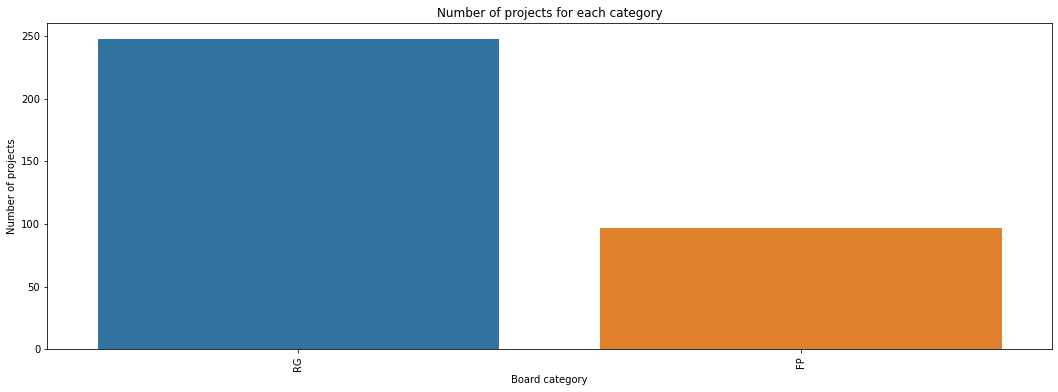

In [10]:
# explore projects by category
plt.figure(figsize=(18, 6))
sns.countplot(df['category'],order = df['category'].value_counts().index)
plt.xticks(rotation = 90);
plt.xlabel('Board category')
plt.ylabel('Number of projects')
plt.title('Number of projects for each category');

Observation: the rigid boards are more than double the number of flex designs

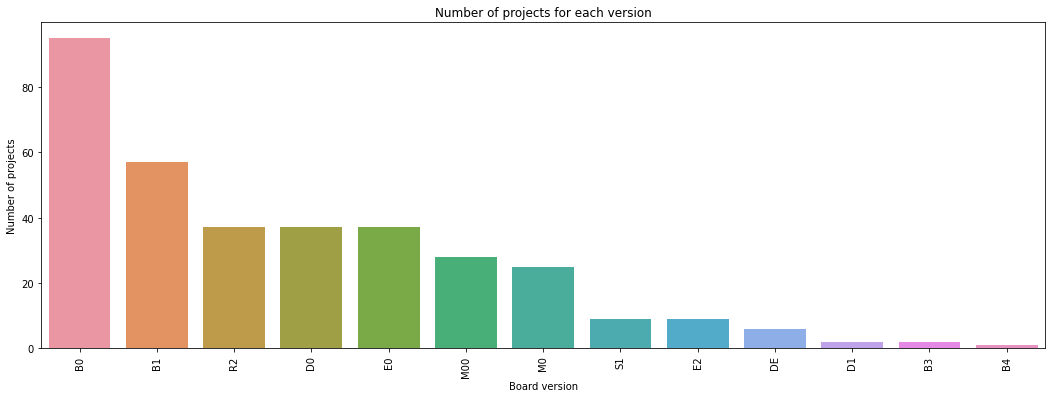

In [11]:
# explore projects by version
plt.figure(figsize=(18, 6))
sns.countplot(df['ver'],order = df['ver'].value_counts().index)
plt.xticks(rotation = 90);
plt.xlabel('Board version')
plt.ylabel('Number of projects')
plt.title('Number of projects for each version');

B0 and B1 versions are much larger in number than the rest of the categories

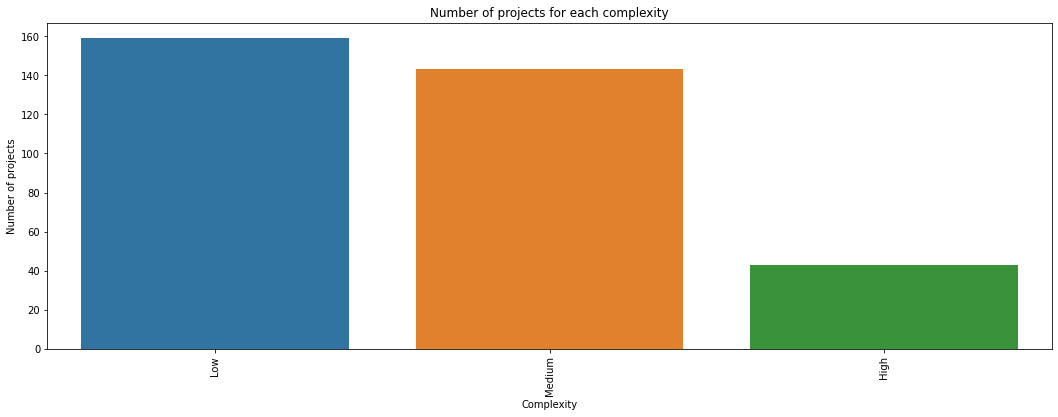

In [12]:
# explore projects by complexity
plt.figure(figsize=(18, 6))
sns.countplot(df['complexity'],order = df['complexity'].value_counts().index)
plt.xticks(rotation = 90);
plt.xlabel('Complexity')
plt.ylabel('Number of projects')
plt.title('Number of projects for each complexity');

Observation: Low complexity projects are similar in number as the medium and high combined. In practice, only two classes are used, low or high complexity, but for this analysis I will use the three classes

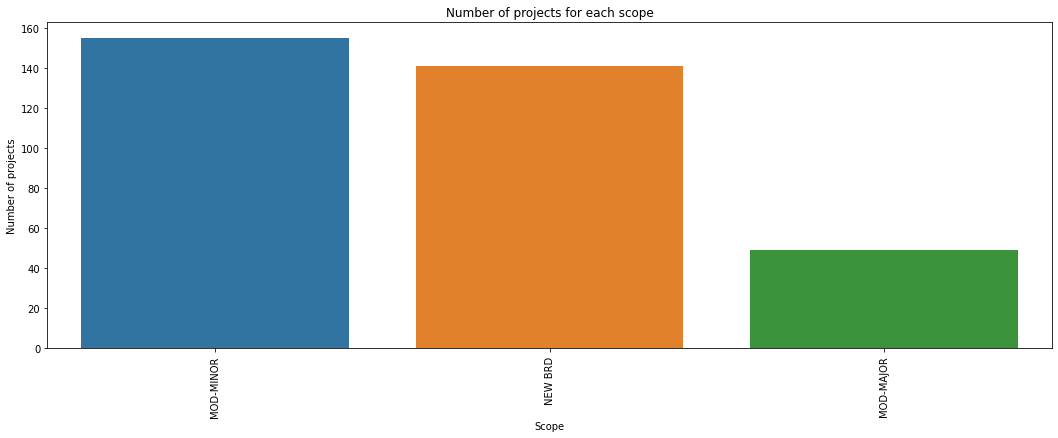

In [13]:
# explore projects by scope
plt.figure(figsize=(18, 6))
sns.countplot(df['scope'],order = df['scope'].value_counts().index)
plt.xticks(rotation = 90);
plt.xlabel('Scope')
plt.ylabel('Number of projects')
plt.title('Number of projects for each scope');

Observation: new boards and minor mods are each more than double the major mods. However, it must be noted that in practice minor or major mods refer to the quantity, not the quality, such that a minor mod in fact can take a lot of time to do so this might not related to the design duration as one would expect. 

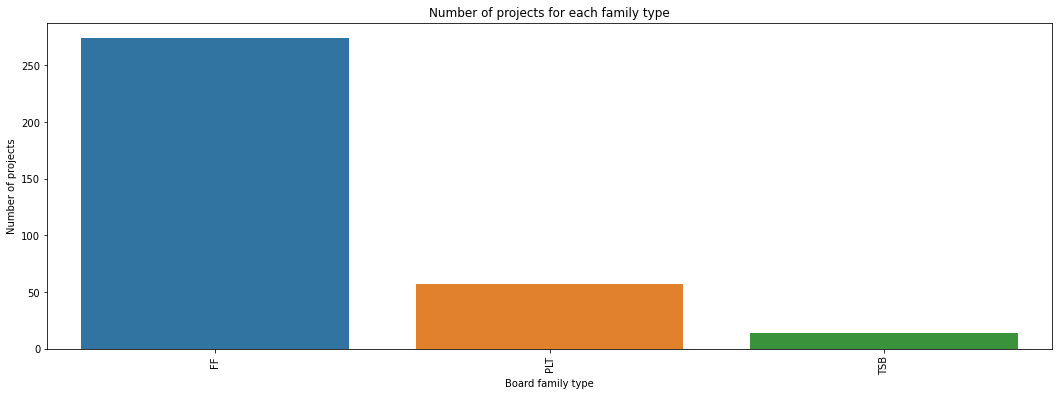

In [14]:
# explore projects by board family type
plt.figure(figsize=(18, 6))
sns.countplot(df['type'],order = df['type'].value_counts().index)
plt.xticks(rotation = 90);
plt.xlabel('Board family type')
plt.ylabel('Number of projects')
plt.title('Number of projects for each family type');

Observation: TSB and PLT together are less than a half FF

Explore the mean duration of the design for various features

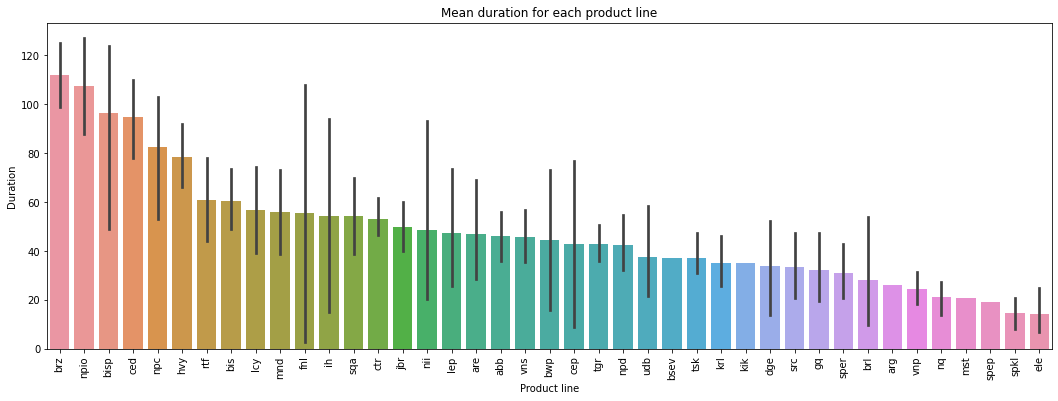

In [15]:
# mean duration for different product lines
plt.figure(figsize=(18, 6))
sns.barplot(data = df, x = 'line', y = 'duration',
           order = df.groupby(['line'])['duration'].mean().sort_values(ascending = False).index)
plt.xticks(rotation = 90);
plt.xlabel('Product line')
plt.ylabel('Duration')
plt.title('Mean duration for each product line');

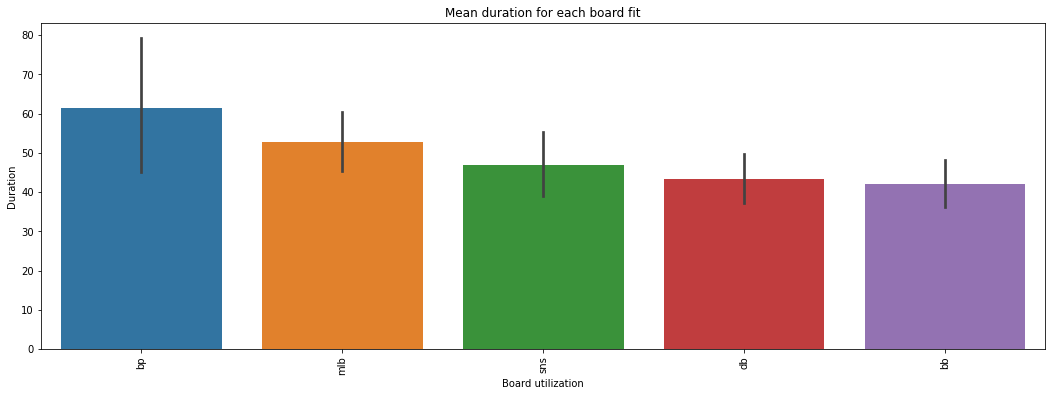

In [16]:
# mean duration for different fits
plt.figure(figsize=(18, 6))
sns.barplot(data = df, x = 'fit', y = 'duration',
           order = df.groupby(['fit'])['duration'].mean().sort_values(ascending = False).index)
plt.xticks(rotation = 90);
plt.xlabel('Board utilization')
plt.ylabel('Duration')
plt.title('Mean duration for each board fit');

Observation: Duration is similar for the five categories

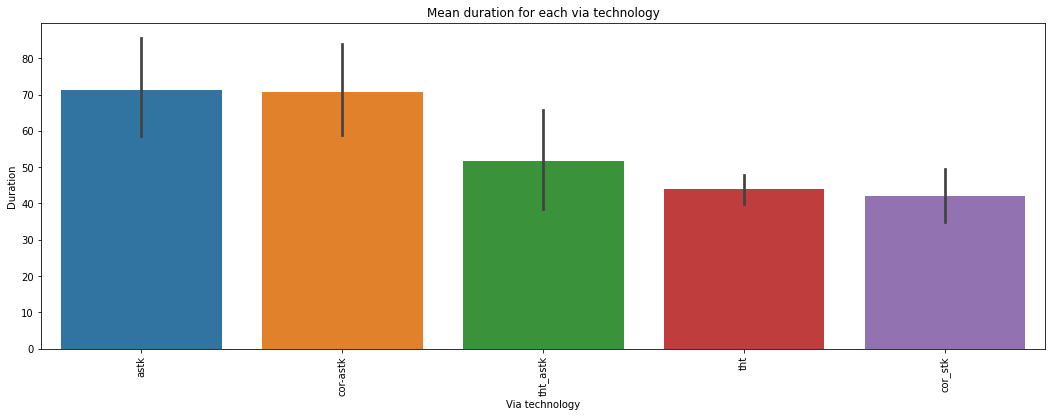

In [17]:
# mean duration for different via technologies
plt.figure(figsize=(18, 6))
sns.barplot(data = df, x = 'viatech', y = 'duration',
           order = df.groupby(['viatech'])['duration'].mean().sort_values(ascending = False).index)
plt.xticks(rotation = 90);
plt.xlabel('Via technology')
plt.ylabel('Duration')
plt.title('Mean duration for each via technology');

Observation: as expected, boards with astk and cor-astk via tech lead to a longer design duration

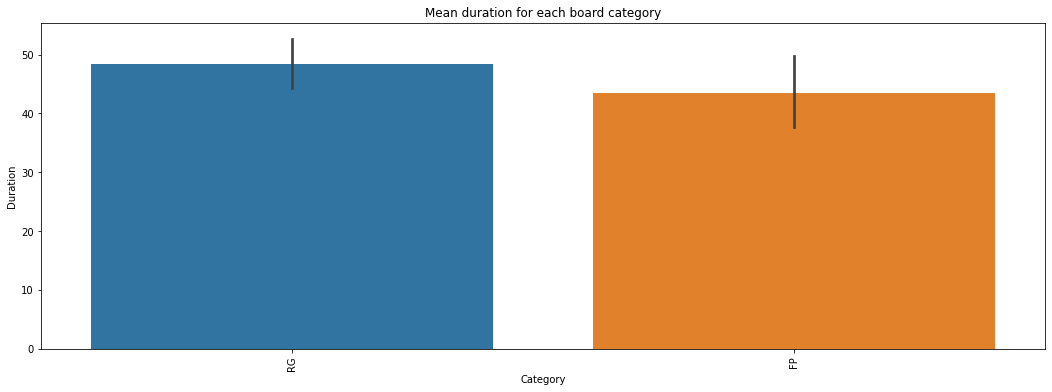

In [18]:
# mean duration by board category
plt.figure(figsize=(18, 6))
sns.barplot(data = df, x = 'category', y = 'duration',
           order = df.groupby(['category'])['duration'].mean().sort_values(ascending = False).index)
plt.xticks(rotation = 90);
plt.xlabel('Category')
plt.ylabel('Duration')
plt.title('Mean duration for each board category');

Obsevation: Rigid and flex designs have similar duration

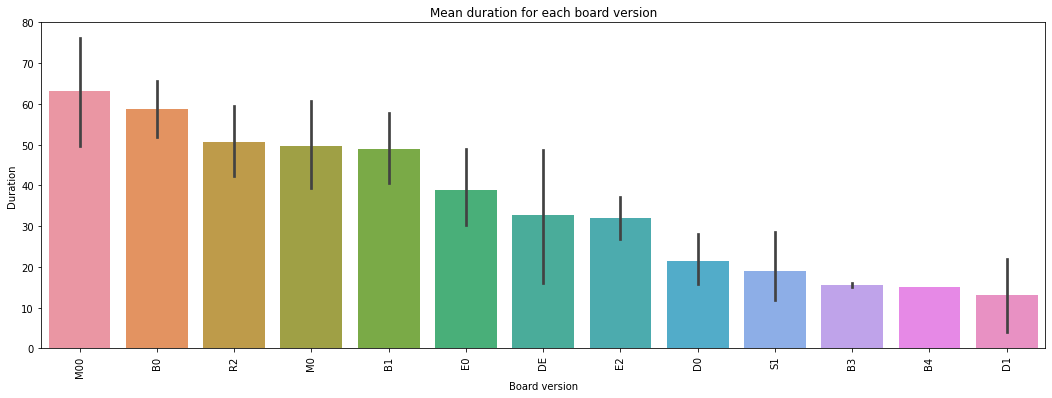

In [19]:
# mean duration by board version
plt.figure(figsize=(18, 6))
sns.barplot(data = df, x = 'ver', y = 'duration',
           order = df.groupby(['ver'])['duration'].mean().sort_values(ascending = False).index)
plt.xticks(rotation = 90);
plt.xlabel('Board version')
plt.ylabel('Duration')
plt.title('Mean duration for each board version');

Observation: As expected, versions M00, B0, B1, M0 and R2 take longer to design

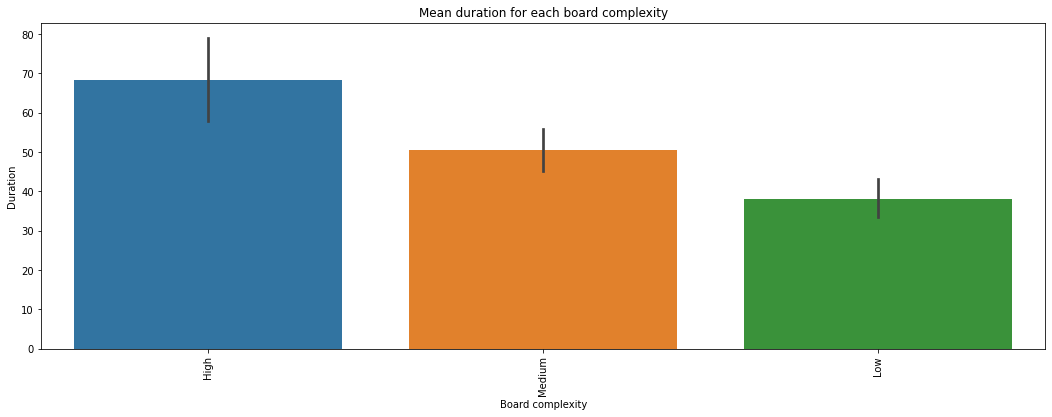

In [20]:
# mean duration by board complexity
plt.figure(figsize=(18, 6))
sns.barplot(data = df, x = 'complexity', y = 'duration',
           order = df.groupby(['complexity'])['duration'].mean().sort_values(ascending = False).index)
plt.xticks(rotation = 90);
plt.xlabel('Board complexity')
plt.ylabel('Duration')
plt.title('Mean duration for each board complexity');

Observation: As expected, higher complexity lead to longer design time

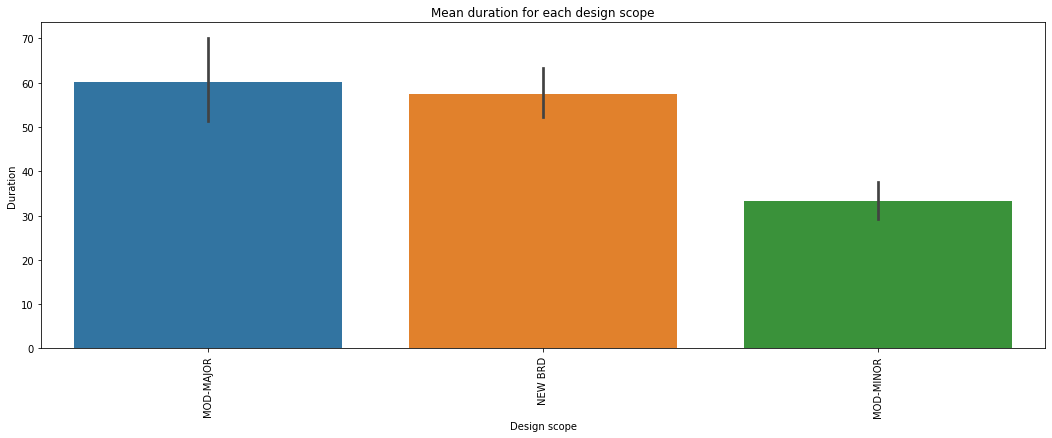

In [21]:
# mean duration by design scope
plt.figure(figsize=(18, 6))
sns.barplot(data = df, x = 'scope', y = 'duration',
           order = df.groupby(['scope'])['duration'].mean().sort_values(ascending = False).index)
plt.xticks(rotation = 90);
plt.xlabel('Design scope')
plt.ylabel('Duration')
plt.title('Mean duration for each design scope');

Observation: New boards and major mods end to take longer to design.

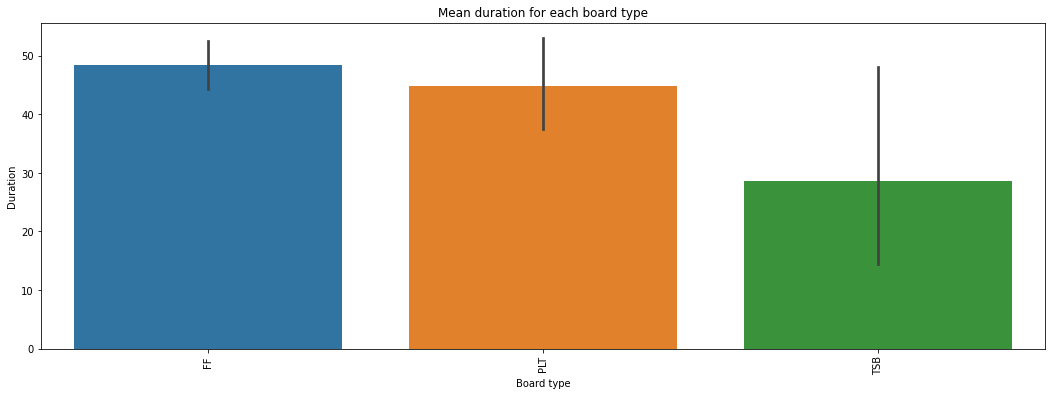

In [22]:
# mean duration by board type
plt.figure(figsize=(18, 6))
sns.barplot(data = df, x = 'type', y = 'duration',
           order = df.groupby(['type'])['duration'].mean().sort_values(ascending = False).index)
plt.xticks(rotation = 90);
plt.xlabel('Board type')
plt.ylabel('Duration')
plt.title('Mean duration for each board type');

Observation: FF and PLT take longer to design than TSB

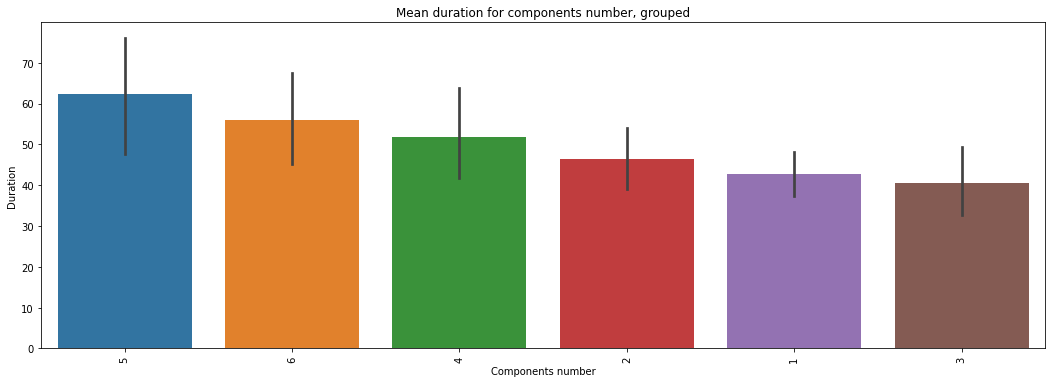

In [23]:
# make comps as groups and plot
df.loc[df['comp'] <= 20, 'comp'] = 1
df.loc[(df['comp'] > 20) & (df['comp'] <= 80), 'comp'] = 2
df.loc[(df['comp'] > 80) & (df['comp'] <= 250), 'comp'] = 3
df.loc[(df['comp'] > 250) & (df['comp'] <= 700), 'comp'] = 4
df.loc[(df['comp'] > 700) & (df['comp'] <= 1200), 'comp'] = 5
df.loc[df['comp'] > 1200, 'comp'] = 6
# plot mean duration by number of components
plt.figure(figsize=(18, 6))
sns.barplot(data = df, x = 'comp', y = 'duration',
           order = df.groupby(['comp'])['duration'].mean().sort_values(ascending = False).index)
plt.xticks(rotation = 90);
plt.xlabel('Components number')
plt.ylabel('Duration')
plt.title('Mean duration for components number, grouped');


Observation: more components lead to longer design time

#### Inspect the categorical features to determine the type of encoding

In [24]:
# binary encoding
len(df['line'].unique())

41

In [25]:
# binary encoding
len(df['fit'].unique())

5

In [26]:
# binary encoding
len(df['viatech'].unique())

5

In [27]:
# OneHotEncoder
len(df['dbl'].unique())

2

In [28]:
# OneHotEncoder
len(df['category'].unique())

2

In [29]:
# binary encoding
len(df['ver'].unique())

13

In [30]:
# OneHotEncoder
len(df['complexity'].unique())

3

In [31]:
# OneHotEncoder
len(df['scope'].unique())

3

In [32]:
# OneHotEncoder
len(df['type'].unique())

3

Suggestion for the column sets:

In [33]:
#column sets
col_ohe = ['dbl', 'category', 'complexity', 'scope', 'type']
col_bin = ['line', 'fit', 'viatech', 'ver']
col_std = ['viano', 'pins', 'layno', 'sq', 'dens', 'netno', 'comp', 'level']

### Data preparation

##### Important observation
The prediction is needed and happens before the design starts when only a limited part of the features are available. Thus, some of the features will be discarded. 

'viano', 'pins', 'sq', 'dens', 'netno', 'level' are features which are not availble before the project starts.

In [34]:
# reload the data and remove the 'ID' column
df = pd.read_csv('projects_wrk36636.csv')
df = df.drop(columns = ['ID'])# ID is automatically generated
df = df.drop(columns = ['viano', 'pins', 'sq', 'dens', 'netno', 'level'])
df = df.dropna()
df

,line,fit,viatech,layno,dbl,comp,category,ver,complexity,scope,type,duration
0,jbr,bb,tht,2,sgl,3,FP,M00,Medium,NEW BRD,FF,40
1,bis,sns,tht,2,dbl,6,RG,R2,Medium,MOD-MINOR,FF,73
2,gq,bb,tht,2,sgl,2,FP,D0,Low,MOD-MINOR,FF,9
3,gq,bb,tht,2,sgl,2,FP,E0,Medium,MOD-MINOR,FF,76
4,ced,bb,tht,2,sgl,2,FP,B0,Low,NEW BRD,FF,43
...,...,...,...,...,...,...,...,...,...,...,...,...
340,tgr,mlb,astk,12,dbl,1401,RG,E0,High,MOD-MAJOR,FF,75
341,tsk,mlb,astk,12,dbl,2173,RG,M0,High,NEW BRD,FF,85
342,tgr,mlb,astk,12,dbl,1402,RG,E2,High,MOD-MINOR,FF,48
343,tgr,mlb,astk,12,dbl,1405,RG,D0,High,MOD-MAJOR,FF,63


'comp' has a lot of distinct values, but it can be changed as a set of ranges for components numbers. 

In [35]:
df.loc[df['comp'] <= 20, 'comp'] = 1
df.loc[(df['comp'] > 20) & (df['comp'] <= 80), 'comp'] = 2
df.loc[(df['comp'] > 80) & (df['comp'] <= 250), 'comp'] = 3
df.loc[(df['comp'] > 250) & (df['comp'] <= 700), 'comp'] = 4
df.loc[(df['comp'] > 700) & (df['comp'] <= 1200), 'comp'] = 5
df.loc[df['comp'] > 1200, 'comp'] = 6

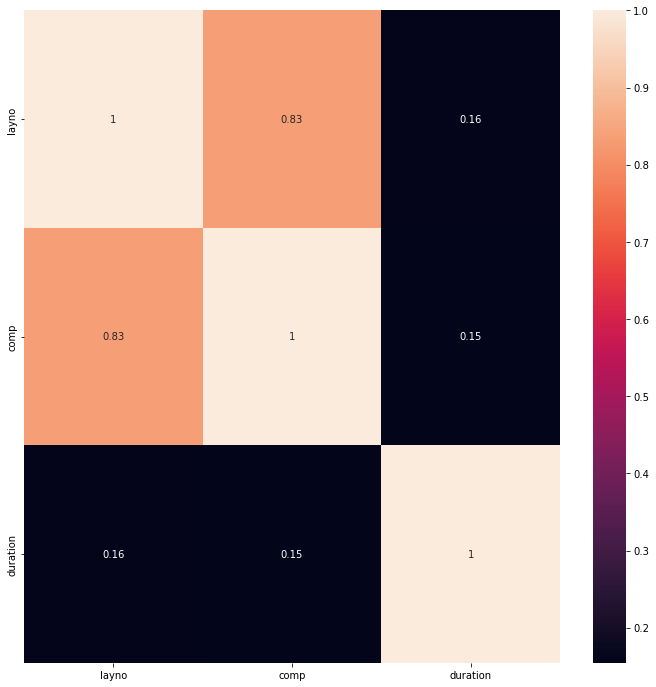

In [36]:
# correlation matrix
fig, ax = plt.subplots(figsize=(12,12)) 
sns.heatmap(df.corr(), annot=True);

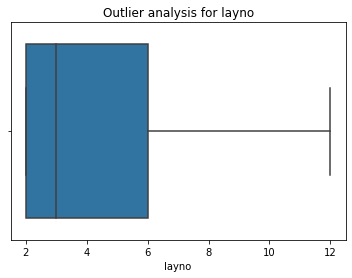

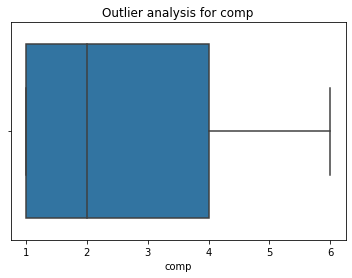

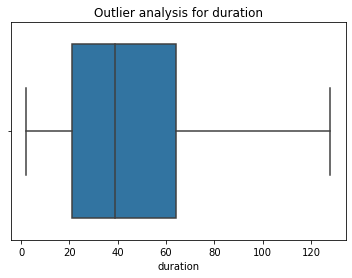

In [37]:
#visualize the outliers for the numeric values.
col_outl = df.select_dtypes(include=['int64','float64']).columns.tolist()
for i in col_outl:
    plt.figure()
    sns.boxplot(x=df[i])
    plt.title('Outlier analysis for '+i)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 345 entries, 0 to 344
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   line        345 non-null    object
 1   fit         345 non-null    object
 2   viatech     345 non-null    object
 3   layno       345 non-null    int64 
 4   dbl         345 non-null    object
 5   comp        345 non-null    int64 
 6   category    345 non-null    object
 7   ver         345 non-null    object
 8   complexity  345 non-null    object
 9   scope       345 non-null    object
 10  type        345 non-null    object
 11  duration    345 non-null    int64 
dtypes: int64(3), object(9)
memory usage: 32.5+ KB


In [39]:
#setting up the train and test sets
X = df.drop(columns = ['duration'])
y = df['duration']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

In [40]:
# calculate the baseline
train_base = np.ones(shape = y_train.shape)*y_train.mean()
test_base = np.ones(shape = y_test.shape)*y_test.mean()
mae_train_base = median_absolute_error(train_base, y_train)
mae_test_base = median_absolute_error(test_base, y_test)
print('\033[1mBASELINE MEDIAN ABSOLUTE ERROR AS REFERENCE:')
print(f'Train baseline MAE: {mae_train_base}')
print(f'Test baseline MAE: {mae_test_base}')

BASELINE MEDIAN ABSOLUTE ERROR AS REFERENCE:
Train baseline MAE: 23.663043478260867
Test baseline MAE: 23.52173913043478


In [41]:
#column sets
col_ohe = ['dbl', 'category', 'complexity', 'scope', 'type']
col_bin = ['line', 'fit', 'viatech', 'ver']
col_std = ['layno', 'comp']

In [42]:
#create the col transformer
transformer = make_column_transformer(
                (OneHotEncoder(drop = 'if_binary'), col_ohe),
                (ce.BinaryEncoder(),col_bin),
                (StandardScaler(), col_std), remainder ='passthrough')

In [43]:
#create first pipeline just with LinearRegression
pipe1 = Pipeline([('transformer', transformer),
                    ('model', LinearRegression())])
pipe1.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['dbl', 'category',
                                                   'complexity', 'scope',
                                                   'type']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['line', 'fit', 'viatech',
                                                   'ver']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['layno', 'comp'])])),
                ('model', LinearRegression())])

In [44]:
pred1_train = pipe1.predict(X_train)
pred1_test = pipe1.predict(X_test)
score1 = pipe1.score(X_test, y_test)
print(f'Pipe1 Train MAE: {median_absolute_error(y_train, pred1_train)}')
print(f'Pipe1 Test MAE: {median_absolute_error(y_test, pred1_test)}')
print(f'Pipe1 Accuracy Score: {score1}')
values = []
values.append(['Linear', median_absolute_error(y_train, pred1_train),median_absolute_error(y_test, pred1_test),
             score1])

Pipe1 Train MAE: 17.70695301149741
Pipe1 Test MAE: 18.862654765627767
Pipe1 Accuracy Score: 0.2523957506219575


In [45]:
#pipe 2 with Ridge default
pipe2 = Pipeline([('transformer', transformer),
                    ('model', Ridge(random_state = 10))])
pipe2.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['dbl', 'category',
                                                   'complexity', 'scope',
                                                   'type']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['line', 'fit', 'viatech',
                                                   'ver']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['layno', 'comp'])])),
                ('model', Ridge(random_state=10))])

In [46]:
pred2_train = pipe2.predict(X_train)
pred2_test = pipe2.predict(X_test)
score2 = pipe2.score(X_test, y_test)
print(f'Pipe2 Train MAE: {median_absolute_error(y_train, pred2_train)}')
print(f'Pipe2 Test MAE: {median_absolute_error(y_test, pred2_test)}')
print(f'Pipe2 Accuracy Score: {score2}')
values.append(['Ridge', median_absolute_error(y_train, pred2_train),median_absolute_error(y_test, pred2_test),
             score2])

Pipe2 Train MAE: 17.645737705264867
Pipe2 Test MAE: 19.15504202353587
Pipe2 Accuracy Score: 0.2564556392819003


In [47]:
#pipe 3 with Lasso default
pipe3 = Pipeline([('transformer', transformer),
                    ('model', Lasso(random_state = 10))])
pipe3.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['dbl', 'category',
                                                   'complexity', 'scope',
                                                   'type']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['line', 'fit', 'viatech',
                                                   'ver']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['layno', 'comp'])])),
                ('model', Lasso(random_state=10))])

In [48]:
pred3_train = pipe3.predict(X_train)
pred3_test = pipe3.predict(X_test)
score3 = pipe3.score(X_test, y_test)
print(f'Pipe3 Train MAE: {median_absolute_error(y_train, pred3_train)}')
print(f'Pipe3 Test MAE: {median_absolute_error(y_test, pred3_test)}')
print(f'Pipe3 Accuracy Score: {score3}')
values.append(['Lasso', median_absolute_error(y_train, pred3_train),median_absolute_error(y_test, pred3_test),
             score3])

Pipe3 Train MAE: 19.278724735235095
Pipe3 Test MAE: 19.18529011239268
Pipe3 Accuracy Score: 0.2486793896539723


In [49]:
#pipe 4 with TransformedTargetRegressor with Ridge regressor
pipe4 = Pipeline([('transformer', transformer),
                    ('model', TransformedTargetRegressor(regressor=Ridge(), func=np.log, inverse_func=np.exp))])
pipe4.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['dbl', 'category',
                                                   'complexity', 'scope',
                                                   'type']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['line', 'fit', 'viatech',
                                                   'ver']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['layno', 'comp'])])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Ridge()))])

In [50]:
pred4_train = pipe4.predict(X_train)
pred4_test = pipe4.predict(X_test)
score4 = pipe4.score(X_test, y_test)
print(f'Pipe4 Train MAE: {median_absolute_error(y_train, pred4_train)}')
print(f'Pipe4 Test MAE: {median_absolute_error(y_test, pred4_test)}')
print(f'Pipe4 Accuracy Score: {score4}')
values.append(['TTR_Ridge', median_absolute_error(y_train, pred4_train),median_absolute_error(y_test, pred4_test),
             score4])

Pipe4 Train MAE: 13.322096406953278
Pipe4 Test MAE: 14.748381701533422
Pipe4 Accuracy Score: 0.26151136388209206


In [51]:
#pipe 5 with TransformedTargetRegressor with RFR as regressor
pipe5 = Pipeline([('transformer', transformer),
            ('model', TransformedTargetRegressor(regressor = RandomForestRegressor(n_estimators = 5, 
                                        random_state = 41), func=np.log, inverse_func=np.exp))])
pipe5.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['dbl', 'category',
                                                   'complexity', 'scope',
                                                   'type']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['line', 'fit', 'viatech',
                                                   'ver']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['layno', 'comp'])])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=RandomForestRegressor(n_estimators=5,
                                                                            random_state=41)))])

In [52]:
pred5_train = pipe5.predict(X_train)
pred5_test = pipe5.predict(X_test)
score5 = pipe5.score(X_test, y_test)
print(f'Pipe5 Train MAE: {median_absolute_error(y_train, pred5_train)}')
print(f'Pipe5 Test MAE: {median_absolute_error(y_test, pred5_test)}')
print(f'Pipe5 Accuracy Score: {score5}')
values.append(['TTR_RFR', median_absolute_error(y_train, pred5_train),median_absolute_error(y_test, pred5_test),
             score5])

Pipe5 Train MAE: 5.11438532494801
Pipe5 Test MAE: 13.567752004052949
Pipe5 Accuracy Score: 0.42262863867752565


In [53]:
#pipe 6 with TransformedTargetRegressor and Lasso as regressor
pipe6 = Pipeline([('transformer', transformer),
            ('model', TransformedTargetRegressor(regressor = Lasso(random_state = 22)))])
pipe6.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['dbl', 'category',
                                                   'complexity', 'scope',
                                                   'type']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['line', 'fit', 'viatech',
                                                   'ver']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['layno', 'comp'])])),
                ('model',
                 TransformedTargetRegressor(regressor=Lasso(random_state=22)))])

In [54]:
pred6_train = pipe6.predict(X_train)
pred6_test = pipe6.predict(X_test)
score6 = pipe6.score(X_test, y_test)
print(f'Pipe6 Train MAE: {median_absolute_error(y_train, pred6_train)}')
print(f'Pipe6 Test MAE: {median_absolute_error(y_test, pred6_test)}')
print(f'Pipe6 Accuracy Score: {score6}')
values.append(['TTR_Lasso', median_absolute_error(y_train, pred6_train),median_absolute_error(y_test, pred6_test),
             score6])

Pipe6 Train MAE: 19.278724735235095
Pipe6 Test MAE: 19.18529011239268
Pipe6 Accuracy Score: 0.2486793896539723


In [55]:
#visualize all the results in one table
table1 = pd.DataFrame(values, columns = ['Model', 'Train MAE', 'Test MAE', 'Score'])
table1 = table1.set_index('Model')
print('\033[1m  Comparison Table for models')
table1

  Comparison Table for models


,Train MAE,Test MAE,Score
Model,,,
Linear,17.706953,18.862655,0.252396
Ridge,17.645738,19.155042,0.256456
Lasso,19.278725,19.185290,0.248679
TTR_Ridge,13.322096,14.748382,0.261511
TTR_RFR,5.114385,13.567752,0.422629
TTR_Lasso,19.278725,19.185290,0.248679


In [56]:
>>> scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']
>>> r_multi = permutation_importance(pipe5, X_test, y_test,
...                            n_repeats=30,
...                            random_state=0, scoring = scoring)
...
>>> for metric in r_multi:
...     print(f"{metric}")
...     r = r_multi[metric]
...     for i in r.importances_mean.argsort()[::-1]:
...         if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
...             print(f"    {X_test.columns[i]:<8}"
...                   f"          {r.importances_mean[i]:.3f}"
...                   f"              +/- {r.importances_std[i]:.3f}")

r2
    scope             0.525              +/- 0.159
    ver               0.318              +/- 0.083
    line              0.299              +/- 0.104
    complexity          0.226              +/- 0.068
    dbl               0.074              +/- 0.023
neg_mean_absolute_percentage_error
    line              0.230              +/- 0.103
    ver               0.221              +/- 0.079
    scope             0.207              +/- 0.099
    type              0.175              +/- 0.053
neg_mean_squared_error
    scope             554.789              +/- 168.359
    ver               336.556              +/- 87.656
    line              316.411              +/- 109.592
    complexity          238.384              +/- 72.192
    dbl               78.217              +/- 24.270


In [57]:
#grid for pipe 5
param5 = {'model__regressor__n_estimators': range(1, 20, 1),
         'model__regressor__random_state': range(1, 42, 1)}
pipe5a = Pipeline([('transformer', transformer),
            ('model', TransformedTargetRegressor(regressor = RandomForestRegressor(), 
                                                 func=np.log, inverse_func=np.exp))])
pipe5a.fit(X_train, y_train)
grid5 = GridSearchCV(pipe5a, param5, scoring = 'r2')
grid5.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['dbl',
                                                                          'category',
                                                                          'complexity',
                                                                          'scope',
                                                                          'type']),
                                                                        ('binaryencoder',
                                                                         BinaryEncoder(),
                                                                         ['line',
                                                                          'fit',
                                                                          'viatech',
                                                                          'ver']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['layno',
                                                                          'comp'])])),
                                       ('model',
                                        TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=RandomForestRegressor()))]),
             param_grid={'model__regressor__n_estimators': range(1, 20),
                         'model__regressor__random_state': range(1, 42)},
             scoring='r2')

In [58]:
pred_train_grid5 = grid5.predict(X_train)
pred_test_grid5 = grid5.predict(X_test)
grid5_train_mae = median_absolute_error(y_train, pred_train_grid5)
grid5_test_mae = median_absolute_error(y_test, pred_test_grid5)
print(f'Grid2 Train MAE: {round(grid5_train_mae, 2)}')
print(f'Grid2 Test MAE: {round(grid5_test_mae, 2)}')
print(f'Best parameter: {grid5.best_params_}')
print(f'Best score: {grid5.best_score_}')
values.append(['Grid_TTR-RFR', grid5_train_mae, grid5_test_mae,grid5.best_score_])

Grid2 Train MAE: 5.33
Grid2 Test MAE: 13.3
Best parameter: {'model__regressor__n_estimators': 13, 'model__regressor__random_state': 18}
Best score: 0.2952879178237541


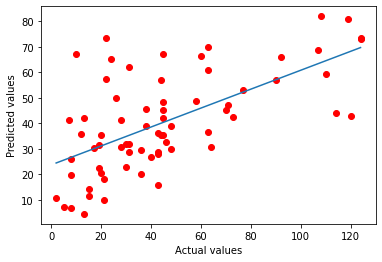

In [59]:
plt.plot(y_test, pred_test_grid5, 'ro')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot(np.unique(y_test), np.poly1d(np.polyfit(y_test, pred_test_grid5, 1))(np.unique(y_test)))
plt.show()

In [60]:
#GridSearchCV parameters
param1 = {'model__regressor__alpha': np.logspace(0, 10, 10)}
param2 = {'model__alpha': np.logspace(0, 10, 10)}

In [61]:
#grid for pipe2
param2 = {'model__alpha': np.logspace(0, 10, 10), 'model__random_state': range(1, 42, 1)}
grid2 = GridSearchCV(pipe2, param2)
grid2.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['dbl',
                                                                          'category',
                                                                          'complexity',
                                                                          'scope',
                                                                          'type']),
                                                                        ('binaryencoder',
                                                                         BinaryEncoder(),
                                                                         ['line',
                                                                          'fit',
                                                                          'viatech',
                                                                          'ver']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['layno',
                                                                          'comp'])])),
                                       ('model', Ridge(random_state=10))]),
             param_grid={'model__alpha': array([1.00000000e+00, 1.29154967e+01, 1.66810054e+02, 2.15443469e+03,
       2.78255940e+04, 3.59381366e+05, 4.64158883e+06, 5.99484250e+07,
       7.74263683e+08, 1.00000000e+10]),
                         'model__random_state': range(1, 42)})

In [62]:
pred_train_grid2 = grid2.predict(X_train)
pred_test_grid2 = grid2.predict(X_test)
grid2_train_mae = median_absolute_error(y_train, pred_train_grid2)
grid2_test_mae = median_absolute_error(y_test, pred_test_grid2)
print(f'Grid2 Train MAE: {round(grid2_train_mae, 2)}')
print(f'Grid2 Test MAE: {round(grid2_test_mae, 2)}')
print(f'Best parameter: {grid2.best_params_}')
print(f'Best score: {grid2.best_score_}')
values.append(['Grid_Ridge', grid2_train_mae, grid2_test_mae,grid2.best_score_])

Grid2 Train MAE: 17.65
Grid2 Test MAE: 17.77
Best parameter: {'model__alpha': 12.91549665014884, 'model__random_state': 1}
Best score: 0.20576592914848052


In [63]:
#grid for pipe3
param3 = {'model__alpha': np.logspace(0, 10, 10), 'model__random_state': range(1, 42, 1)}
grid3 = GridSearchCV(pipe3, param3)
grid3.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['dbl',
                                                                          'category',
                                                                          'complexity',
                                                                          'scope',
                                                                          'type']),
                                                                        ('binaryencoder',
                                                                         BinaryEncoder(),
                                                                         ['line',
                                                                          'fit',
                                                                          'viatech',
                                                                          'ver']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['layno',
                                                                          'comp'])])),
                                       ('model', Lasso(random_state=10))]),
             param_grid={'model__alpha': array([1.00000000e+00, 1.29154967e+01, 1.66810054e+02, 2.15443469e+03,
       2.78255940e+04, 3.59381366e+05, 4.64158883e+06, 5.99484250e+07,
       7.74263683e+08, 1.00000000e+10]),
                         'model__random_state': range(1, 42)})

In [64]:
pred_train_grid3 = grid3.predict(X_train)
pred_test_grid3 = grid3.predict(X_test)
grid3_train_mae = median_absolute_error(y_train, pred_train_grid3)
grid3_test_mae = median_absolute_error(y_test, pred_test_grid3)
print(f'Grid3 Train MAE: {round(grid3_train_mae, 2)}')
print(f'Grid3 Test MAE: {round(grid3_test_mae, 2)}')
print(f'Best parameter: {grid3.best_params_}')
print(f'Best score: {grid3.best_score_}')
values.append(['Grid_Lasso', grid3_train_mae, grid3_test_mae,grid3.best_score_])

Grid3 Train MAE: 19.28
Grid3 Test MAE: 19.19
Best parameter: {'model__alpha': 1.0, 'model__random_state': 1}
Best score: 0.1896144869352531


In [65]:
#grid for pipe 4
param4 = {'model__regressor__alpha': np.logspace(0, 10, 10)}
grid4 = GridSearchCV(pipe4, param4)
grid4.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['dbl',
                                                                          'category',
                                                                          'complexity',
                                                                          'scope',
                                                                          'type']),
                                                                        ('binaryencoder',
                                                                         BinaryEncoder(),
                                                                         ['line',
                                                                          'fit',
                                                                          'viatech',
                                                                          'ver']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['layno',
                                                                          'comp'])])),
                                       ('model',
                                        TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=Ridge()))]),
             param_grid={'model__regressor__alpha': array([1.00000000e+00, 1.29154967e+01, 1.66810054e+02, 2.15443469e+03,
       2.78255940e+04, 3.59381366e+05, 4.64158883e+06, 5.99484250e+07,
       7.74263683e+08, 1.00000000e+10])})

In [66]:
pred_train_grid4 = grid4.predict(X_train)
pred_test_grid4 = grid4.predict(X_test)
grid4_train_mae = median_absolute_error(y_train, pred_train_grid4)
grid4_test_mae = median_absolute_error(y_test, pred_test_grid4)
print(f'Grid4 Train MAE: {round(grid4_train_mae, 2)}')
print(f'Grid4 Test MAE: {round(grid4_test_mae, 2)}')
print(f'Best parameter: {grid4.best_params_}')
print(f'Best score: {grid4.best_score_}')
values.append(['Grid_TTR_Ridge', grid4_train_mae, grid4_test_mae,grid4.best_score_])

Grid4 Train MAE: 13.99
Grid4 Test MAE: 15.8
Best parameter: {'model__regressor__alpha': 12.91549665014884}
Best score: 0.11803809151250173


In [67]:
#grid for pipe 6
param6 = {'model__regressor__alpha': np.logspace(0, 10, 10), 'model__regressor__random_state': range(1, 42, 1)}
grid6 = GridSearchCV(pipe6, param6)
grid6.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['dbl',
                                                                          'category',
                                                                          'complexity',
                                                                          'scope',
                                                                          'type']),
                                                                        ('binaryencoder',
                                                                         BinaryEncoder(),
                                                                         ['line',
                                                                          'fit',
                                                                          'viatech',
                                                                          'ver']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['layno',
                                                                          'comp'])])),
                                       ('model',
                                        TransformedTargetRegressor(regressor=Lasso(random_state=22)))]),
             param_grid={'model__regressor__alpha': array([1.00000000e+00, 1.29154967e+01, 1.66810054e+02, 2.15443469e+03,
       2.78255940e+04, 3.59381366e+05, 4.64158883e+06, 5.99484250e+07,
       7.74263683e+08, 1.00000000e+10]),
                         'model__regressor__random_state': range(1, 42)})

In [68]:
pred_train_grid6 = grid6.predict(X_train)
pred_test_grid6 = grid6.predict(X_test)
grid6_train_mae = median_absolute_error(y_train, pred_train_grid6)
grid6_test_mae = median_absolute_error(y_test, pred_test_grid6)
print(f'Grid6 Train MAE: {round(grid6_train_mae, 2)}')
print(f'Grid6 Test MAE: {round(grid6_test_mae, 2)}')
print(f'Best parameter: {grid6.best_params_}')
print(f'Best score: {grid6.best_score_}')
values.append(['Grid_TTR_Lasso', grid6_train_mae, grid6_test_mae,grid6.best_score_])

Grid6 Train MAE: 19.28
Grid6 Test MAE: 19.19
Best parameter: {'model__regressor__alpha': 1.0, 'model__regressor__random_state': 1}
Best score: 0.1896144869352531


In [69]:
#visualize all the results in one table
table1 = pd.DataFrame(values, columns = ['Model', 'Train MAE', 'Test MAE', 'Score'])
table1 = table1.set_index('Model')
print('\033[1m  Comparison Table for models')
table1

  Comparison Table for models


,Train MAE,Test MAE,Score
Model,,,
Linear,17.706953,18.862655,0.252396
Ridge,17.645738,19.155042,0.256456
Lasso,19.278725,19.185290,0.248679
TTR_Ridge,13.322096,14.748382,0.261511
TTR_RFR,5.114385,13.567752,0.422629
TTR_Lasso,19.278725,19.185290,0.248679
Grid_TTR-RFR,5.325523,13.296457,0.295288
Grid_Ridge,17.646523,17.774117,0.205766
Grid_Lasso,19.278725,19.185290,0.189614


### Improve the model

As the next step, we can try and run the model on an updated data set which takes only the important features and drops the rest.

In [70]:
# from the feature importance: 'scope','line','complexity','comp','ver','type'

In [71]:
df1 = df[['scope','line','complexity','comp','ver','type', 'duration']]
df1.head(3)

,scope,line,complexity,comp,ver,type,duration
0,NEW BRD,jbr,Medium,1,M00,FF,40
1,MOD-MINOR,bis,Medium,1,R2,FF,73
2,MOD-MINOR,gq,Low,1,D0,FF,9


In [72]:
Xf = df1.drop('duration', axis = 1)
yf = df['duration']
Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xf, yf, test_size = 0.2, random_state = 10)

In [73]:
col_ohe_final = ['complexity', 'scope', 'type']
col_bin_final = ['line','ver']
col_std_final = ['comp']

In [74]:
transf_final = make_column_transformer(
                (OneHotEncoder(drop="if_binary"), col_ohe_final),
                (ce.BinaryEncoder(),col_bin_final),
                (StandardScaler(), col_std_final), remainder ='passthrough')

In [75]:
pipe_f = Pipeline([('transformer', transf_final),
            ('model', TransformedTargetRegressor(regressor = RandomForestRegressor(), 
                                                 func=np.log, inverse_func=np.exp))])
pipe_f.fit(Xf_train, yf_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['complexity', 'scope',
                                                   'type']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['line', 'ver']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['comp'])])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=RandomForestRegressor()))])

In [76]:
#grid for pipe final
param_f = {'model__regressor__n_estimators': range(1, 20, 1),
         'model__regressor__random_state': range(1, 42, 1)}
grid_f = GridSearchCV(pipe_f, param_f, scoring = 'r2')
grid_f.fit(Xf_train, yf_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='if_binary'),
                                                                         ['complexity',
                                                                          'scope',
                                                                          'type']),
                                                                        ('binaryencoder',
                                                                         BinaryEncoder(),
                                                                         ['line',
                                                                          'ver']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['comp'])])),
                                       ('model',
                                        TransformedTargetRegressor(func=<ufunc 'log'>,
                                                                   inverse_func=<ufunc 'exp'>,
                                                                   regressor=RandomForestRegressor()))]),
             param_grid={'model__regressor__n_estimators': range(1, 20),
                         'model__regressor__random_state': range(1, 42)},
             scoring='r2')

In [77]:
pred_train_grid_f = grid_f.predict(Xf_train)
pred_test_grid_f = grid_f.predict(Xf_test)
grid_f_train_mae = median_absolute_error(yf_train, pred_train_grid_f)
grid_f_test_mae = median_absolute_error(yf_test, pred_test_grid_f)
print(f'Grid2 Train MAE: {round(grid_f_train_mae, 2)}')
print(f'Grid2 Test MAE: {round(grid_f_test_mae, 2)}')
print(f'Best parameter: {grid_f.best_params_}')
print(f'Best score: {grid_f.best_score_}')

Grid2 Train MAE: 5.43
Grid2 Test MAE: 12.82
Best parameter: {'model__regressor__n_estimators': 13, 'model__regressor__random_state': 6}
Best score: 0.2925901585889648


In [78]:
# inserting the best parameters in the final pipe
pipe_final = Pipeline([('transformer', transf_final),
            ('model', TransformedTargetRegressor(regressor = RandomForestRegressor(n_estimators = 9,
                                                random_state = 38), 
                                                func=np.log, inverse_func=np.exp))])
pipe_final.fit(Xf_train, yf_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['complexity', 'scope',
                                                   'type']),
                                                 ('binaryencoder',
                                                  BinaryEncoder(),
                                                  ['line', 'ver']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['comp'])])),
                ('model',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=RandomForestRegressor(n_estimators=9,
                                                                            random_state=38)))])

In [79]:
pred_final_train = pipe_final.predict(Xf_train)
pred_final_test = pipe_final.predict(Xf_test)
score_final = pipe_final.score(Xf_test, yf_test)
print(f'Pipe_final Train MAE: {median_absolute_error(yf_train, pred_final_train)}')
print(f'Pipe_final Test MAE: {median_absolute_error(yf_test, pred_final_test)}')
print(f'Pipe_final Accuracy Score: {score_final}')

Pipe_final Train MAE: 5.069325557074565
Pipe_final Test MAE: 11.530281167808276
Pipe_final Accuracy Score: 0.36124569606842216


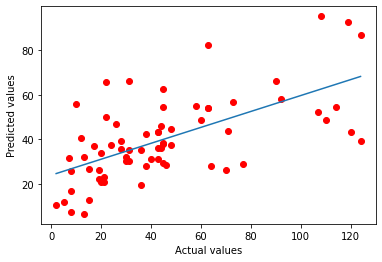

In [80]:
plt.plot(yf_test, pred_final_test, 'ro')
plt.xlabel('Actual values')
plt.ylabel('Predicted values')
plt.plot(np.unique(yf_test), np.poly1d(np.polyfit(yf_test, pred_final_test, 1))(np.unique(yf_test)))
plt.show()

Above is the r2 plot

### Conclusions
1. The models can predict, but with very low score, even if the MAE is better than the baseline
2. The dataset does not have too many entries which limits the training of the models.
3. Much more data is needed to allow for a good training of the models
#### The most important conclusions:
4. The dataset cannot capture the unexpected factors which affect a design along the way. The data has been entered at the end of a project, thus the duration was the real duration as registered at the end of the design. What is important here is that the dataset cannot capture the real events along a project, such as changes and blockers, which delay the design and adds to the overall duration. A design which normally takes 30 days, can be in fact much longer, 60 days or more, due to continuous changes and difficult technical requirements. So, even if the features recorded in the dataset indicate a theoretical duration, in reality the duration can differ vastly.
5. The quality of the data might not be the best, since it was collected with no purpose of this kind in mind.
6. The prediction model can be used as a loose indicator, a pure estimation. It can be useful for the business purpose of scheduling, since the result is theoretically correct. In this particular business case, low accuracy can be accepted.
7. Score and MAE have been used for evaluating the models. All models performed better than the baseline, but the score is very low. In itself, this can be accepted if the accuracy is not a requirement, such as in this case.  
8. The best model is TransformedTargetRegressor with regressor = RandomForestRegressor, with tuned parameters. 

#### Answers to the initial data task:
    
###### 1. Can I use the available data to build a design duration prediction tool that can help the management to plan the schedules better?
    Yes, if the accuracy is not a requirement and the results can be used as indicators based on the initial project characteristics
###### 2. What data can be ignored, or dropped from the analysis?
    Ignore all the features which in practice are not available before the project is done
###### 3. Do I need to clean up the data and how do I prepare the data?
    Data was clean, preparation included dropping unused columns and encode the data
###### 4. What are the top features that influence the duration of a project?
    'scope','line','complexity','comp','ver','type' have the highest importance
###### 5. Is the model accurate enough? What is missing, how can I improve the data set and the analysis as next steps?
    - No, the model is not accurate at all. 
    - What is missing is much more data to train the models
    - I must find a way to capture the missing 'change' and 'subjective' features which directly affect the duration. 'change' should capture a numeric value which represents the amount or percentage of the changes happening along the design. 'subjective' should capture factors such as the teams, the time of the year, vactions or team changes, changes in priorities, etc. 

#### Overall, through this work, I can provide a  model for predicting the design time, based on a given set of known characteristics, only if the accuracy is not a requirement
#### If accuracy is required, the models are not good enough to make useful predictions with the exising dataset 

### Next steps
1. What can be done to improve the models:
* identify and include additional features which can be collected before the project starts
* collect much more data 
* explore all the available hyperparameters for each model and use larger ranges for the parameters values
* explore other ways to encode the data
* use even fewer features
2. What to advise the organization?
* collect more data, historical or as becomes available and reach out to similar organizations for data
* use the prediction model with the knowledge that it has a very low precision and can be used as an indicator and in conjunction with human input
3. How to use this models in practice?
* integrate the model in a practical prediction application with an easy to use GUI 